# Semantic Word Vectors and Sentiment Analysis
CS 224D Assignment 1  
Spring 2015

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://cs224d.stanford.edu/assignment1) on the course website.*

In this assignment, we will walk you through the process of implementing 

- A softmax function
- A simple neural network
- Back propagation
- Word2vec models

and training your own word vectors with stochastic gradient descent (SGD) for a sentiment analysis task. Please make sure to finish the corresponding problems in the problem set PDF when instructed by the worksheet.

The purpose of this assignment is to familiarize you with basic knowledge about neural networks and machine learning, including optimization and cross-validation, and help you gain proficiency in writing efficient, vectorized code.

** Please don't add or remove any code cells, as it might break our automatic grading system and affect your grade. **

**Honor Code:** I hereby agree to abide the Stanford Honor Code and that of the Computer Science Department, promise that the submitted assignment is my own work, and understand that my code is subject to plagiarism test.

**Signature**: kmr

In [1]:
# Run some setup code for this notebook. Don't modify anything in this cell.

import random
import numpy as np
from cs224d.data_utils import *
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Softmax
*Please answer the first first complementary problem before starting this part.*

Given an input matrix of *N* rows and *d* columns, compute the softmax prediction for each row. That is, when the input is

    [[1,2],
    [3,4]]
    
the output of your functions should be

    [[0.2689, 0.7311],
    [0.2689, 0.7311]]

In [2]:
def softmax(x):
    """ Softmax function """
    ###################################################################
    # Compute the softmax function for the input here.                #
    # It is crucial that this function is optimized for speed because #
    # it will be used frequently in later code.                       #
    # You might find numpy functions np.exp, np.sum, np.reshape,      #
    # np.max, and numpy broadcasting useful for this task. (numpy     #
    # broadcasting documentation:                                     #
    # http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)  #
    # You should also make sure that your code works for one          #
    # dimensional inputs (treat the vector as a row), you might find  #
    # it helpful for your later problems.                             #
    ###################################################################
    
    ### YOUR CODE HERE
    
    # here we take advantage of the fact that softmax is "overparameterized"
    # 
    # http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/
    
    c = np.max(x, x.ndim - 1)
    if x.ndim > 1:
        x = x - c.reshape(len(c), 1) # so the subtraction occurs row wise
    else:
        x = x - c

    x = np.exp(x)
    s = np.sum(x, x.ndim - 1)

    if x.ndim > 1:
        s = s.reshape(len(s), 1) # so the normalization occurs row wise

    x = x / s
    ### END YOUR CODE
    
    return x

In [3]:
# Verify your softmax implementation

print "=== For autograder ==="
print softmax(np.array([[1001,1002],[3,4]]))
print softmax(np.array([[-1001,-1002]]))
print softmax(np.array([[1,2], [3,4]]))

=== For autograder ===
[[ 0.26894142  0.73105858]
 [ 0.26894142  0.73105858]]
[[ 0.73105858  0.26894142]]
[[ 0.26894142  0.73105858]
 [ 0.26894142  0.73105858]]


## 2. Neural network basics

*Please answer the second complementary question before starting this part.*

In this part, you're going to implement

* A sigmoid activation function and its gradient
* A forward propagation for a simple neural network with cross-entropy cost
* A backward propagation algorithm to compute gradients for the parameters
* Gradient / derivative check

In [4]:
def sigmoid(x):
    """ Sigmoid function """
    ###################################################################
    # Compute the sigmoid function for the input here.                #
    ###################################################################
    
    ### YOUR CODE HERE
    x = 1 / (1+np.exp(-x))
    ### END YOUR CODE
    
    return x

def sigmoid_grad(f):
    """ Sigmoid gradient function """
    ###################################################################
    # Compute the gradient for the sigmoid function here. Note that   #
    # for this implementation, the input f should be the sigmoid      #
    # function value of your original input x.                        #
    ###################################################################
    
    ### YOUR CODE HERE
    f = f * (1-f)
    ### END YOUR CODE
    
    return f

In [5]:
# Check your sigmoid implementation
x = np.array([[0, 1, 2], [0, -1, -2]])
f = sigmoid(x)
g = sigmoid_grad(f)
print "=== For autograder ==="
print f
print g

=== For autograder ===
[[ 0.5         0.73105858  0.88079708]
 [ 0.5         0.26894142  0.11920292]]
[[ 0.25        0.19661193  0.10499359]
 [ 0.25        0.19661193  0.10499359]]


Now, use the functions you just implemented, fill in the following functions to implement a neural network with one sigmoid hidden layer. You might find the handout and your answers to the second complementary problem helpful for this part.

In [6]:
# First implement a gradient checker by filling in the following functions
def gradcheck_naive(f, x):
    """ 
    Gradient check for a function f 
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
    
        ### YOUR CODE HERE: try modifying x[ix] with h defined above to compute numerical gradients
        ### make sure you call random.setstate(rndstate) before calling f(x) each time, this will make it 
        ### possible to test cost functions with built in randomness later
        
        #basically we are trying to check that our gradient function produces very similar values to those
        #that would be produced if we just re-evaluated f at a slight delta away and then subtracted
        orig = x[ix]
        x[ix] += h
        random.setstate(rndstate)
        fx_high, _ = f(x)

        x[ix] = orig - h
        random.setstate(rndstate)
        fx_low, _ = f(x)
        numgrad = (fx_high - fx_low)/(2*h)

        x[ix] = orig

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print "Gradient check failed."
            print "First gradient error found at index %s" % str(ix)
            print "Your gradient: %f \t Numerical gradient: %f" % (grad[ix], numgrad)
            return
    
        it.iternext() # Step to next dimension

    print "Gradient check passed!"

In [7]:
# Sanity check for the gradient checker
quad = lambda x: (np.sum(x ** 2), x * 2)

print "=== For autograder ==="
gradcheck_naive(quad, np.array(123.456))      # scalar test
gradcheck_naive(quad, np.random.randn(3,))    # 1-D test
gradcheck_naive(quad, np.random.randn(4,5))   # 2-D test


=== For autograder ===
Gradient check passed!
Gradient check passed!
Gradient check passed!


In [8]:
# Set up fake data and parameters for the neural network
N = 20
dimensions = [10, 5, 10]
data = np.random.randn(N, dimensions[0])   # each row will be a datum
labels = np.zeros((N, dimensions[2]))
for i in xrange(N):
    labels[i,random.randint(0,dimensions[2]-1)] = 1

params = np.random.randn((dimensions[0] + 1) * dimensions[1] + (dimensions[1] + 1) * dimensions[2], )

In [9]:
def forward_backward_prop(data, labels, params):
    """ Forward and backward propagation for a two-layer sigmoidal network """
    ###################################################################
    # Compute the forward propagation and for the cross entropy cost, #
    # and backward propagation for the gradients for all parameters.  #
    ###################################################################

    ### Unpack network parameters (do not modify)
    t = 0
    W1 = np.reshape(params[t:t+dimensions[0]*dimensions[1]], (dimensions[0], dimensions[1]))
    t += dimensions[0]*dimensions[1]
    b1 = np.reshape(params[t:t+dimensions[1]], (1, dimensions[1]))
    t += dimensions[1]
    W2 = np.reshape(params[t:t+dimensions[1]*dimensions[2]], (dimensions[1], dimensions[2]))
    t += dimensions[1]*dimensions[2]
    b2 = np.reshape(params[t:t+dimensions[2]], (1, dimensions[2]))

    ### YOUR CODE HERE: forward propagation
    m = data.shape[0] # number of examples
    Z2 = data.dot(W1)
    I2 = Z2 + b1
    A2 = sigmoid(I2)

    # print '   b1: %s' % str(b1)
    # print 'Z2[0]: %s' % str(Z2[0:1])
    # print 'I2[0]: %s' % str(I2[0:1])
    # print 'A2[0]: %s' % str(A2[0:1])

    Z3 = A2.dot(W2)
    I3 = Z3 + b2
    A3 = softmax(I3)

    # print '   b2: %s' % str(b2)
    # print 'Z3[0]: %s' % str(Z3[0])
    # print 'I3[0]: %s' % str(I3[0])
    # print 'A3[0]: %s' % str(A3[0])
    # print ' y[0]: %s' % str(labels[0])

    C = np.sum(A3 * labels, 1) #start create cost vector per training example
    C = np.log(C)

    cost = -1*np.sum(C) / m
    ### END YOUR CODE

    ### YOUR CODE HERE: backward propagation

    D3 = A3 - labels

    # print '*** shapes ***'
    # print "A2: %s" % str(A2.shape)
    # print "D3: %s" % str(D3.shape)
    # print "W2: %s" % str(W2.shape)

    dW2 = A2.T.dot(D3)

    S2 = sigmoid_grad(A2)

    D2 = S2 * D3.dot(W2.T)
    # print "S2: %s" % str(S2.shape)
    # print "D2: %s" % str(D2.shape)

    dW1 = data.T.dot(D2)

    gradW2 = dW2 / m
    gradb2 = D3.sum(axis=0) / m
    gradW1 = dW1 / m
    gradb1 = D2.sum(axis=0) / m

    # print('*** final ***')
    # print "gradW2 %s" % str(gradW2.shape)
    # print "gradb2 %s" % str(gradb2.shape)
    # print "gradW1 %s" % str(gradW1.shape)
    # print "gradb1 %s" % str(gradb1.shape)

    ### END YOUR CODE

    ### Stack gradients (do not modify)

    grad = np.concatenate((gradW1.flatten(), gradb1.flatten(), gradW2.flatten(), gradb2.flatten()))

    return cost, grad


In [10]:
#forward_backward_prop(data, labels, params)

# Perform gradcheck on your neural network
#print "=== For autograder ==="
gradcheck_naive(lambda params: forward_backward_prop(data, labels, params), params)

Gradient check passed!


## 3. Word2vec

*Please answer the third complementary problem before starting this part.*

In this part you will implement the `word2vec` models and train your own word vectors with stochastic gradient descent (SGD).

In [11]:
# Implement your skip-gram and CBOW models here

# Interface to the dataset for negative sampling
dataset = type('dummy', (), {})()
def dummySampleTokenIdx():
    return random.randint(0, 4)
def getRandomContext(C):
    tokens = ["a", "b", "c", "d", "e"]
    return tokens[random.randint(0,4)], [tokens[random.randint(0,4)] for i in xrange(2*C)]
dataset.sampleTokenIdx = dummySampleTokenIdx
dataset.getRandomContext = getRandomContext

def softmaxCostAndGradient(predicted, target, outputVectors):
    """ Softmax cost function for word2vec models """
    ###################################################################
    # Implement the cost and gradients for one predicted word vector  #
    # and one target word vector as a building block for word2vec     #
    # models, assuming the softmax prediction function and cross      #
    # entropy loss.                                                   #
    # Inputs:                                                         #
    #   - predicted: numpy ndarray, predicted word vector (\hat{r} in #
    #           the written component)                                #
    #   - target: integer, the index of the target word               #
    #   - outputVectors: "output" vectors for all tokens              #
    # Outputs:                                                        #
    #   - cost: cross entropy cost for the softmax word prediction    #
    #   - gradPred: the gradient with respect to the predicted word   #
    #           vector                                                #
    #   - grad: the gradient with respect to all the other word       # 
    #           vectors                                               #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################
    
    ### YOUR CODE HERE
    probabilities = softmax( outputVectors.dot(predicted) )
    t = np.zeros(len(probabilities)) # target index -> one hot target vector
    t[target] = 1

    #see written answers for explanation
    cost = - np.log(probabilities[target])
    gradPred = - outputVectors[target] + outputVectors.T.dot(probabilities)
    grad = np.outer(probabilities - t, predicted)

    return cost, gradPred, grad

def negSamplingCostAndGradient(predicted, target, outputVectors, K=10, printCosts=False):
    """ Negative sampling cost function for word2vec models """
    ###################################################################
    # Implement the cost and gradients for one predicted word vector  #
    # and one target word vector as a building block for word2vec     #
    # models, using the negative sampling technique. K is the sample  #
    # size. You might want to use dataset.sampleTokenIdx() to sample  #
    # a random word index.                                            #
    # Input/Output Specifications: same as softmaxCostAndGradient     #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################

    ### YOUR CODE HERE
    samples = np.zeros((K+1, outputVectors.shape[1]))
    samples[0] = outputVectors[target]
    indices = [target]
    for i in range(1, K+1):
#        neg = target
#        while neg == target:
        neg = dataset.sampleTokenIdx()

        samples[i] = outputVectors[neg]
        indices.append(neg)

    product = samples.dot(predicted)

    sig = sigmoid(product)
    cost = - np.log(sig[0]) - np.sum( np.log(1 - sig)[1:] )

    sig[0] -= 1
    gradPred = samples.T.dot(sig)

    grad = np.zeros(outputVectors.shape)

    # vectorized
#    sample_errs = np.outer(sig, predicted)
#    for i in range(0,K+1):
#        idx = indices[i]
#        grad[idx] += sample_errs[i]

    # unvectorized style
    for i in range(0,K+1):
        idx = indices[i]
        grad[idx] += sig[i] * predicted
    ### END YOUR CODE

    if printCosts:
        print cost
        print gradPred
        print grad
        print '========================='

    return cost, gradPred, grad


def skipgram(currentWord, C, contextWords, tokens, inputVectors, outputVectors, word2vecCostAndGradient = softmaxCostAndGradient):
    """ Skip-gram model in word2vec """
    ###################################################################
    # Implement the skip-gram model in this function.                 #         
    # Inputs:                                                         #
    #   - currentWord: a string of the current center word           #
    #   - C: integer, context size                                    #
    #   - contextWords: list of no more than 2*C strings, the context #
    #             words                                               #
    #   - tokens: a dictionary that maps words to their indices in    #
    #             the word vector list                                #
    #   - inputVectors: "input" word vectors for all tokens           #
    #   - outputVectors: "output" word vectors for all tokens         #
    #   - word2vecCostAndGradient: the cost and gradient function for #
    #             a prediction vector given the target word vectors,  #
    #             could be one of the two cost functions you          #
    #             implemented above                                   #
    # Outputs:                                                        #
    #   - cost: the cost function value for the skip-gram model       #
    #   - grad: the gradient with respect to the word vectors         #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################
    
    ### YOUR CODE HERE
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)
    cost = 0
    
    #for each context word, calculate the cost, cost function gradients and add them up to get 
    #the final, combined cost and gradients
    for i in range(0, len(contextWords)):
        target = tokens[contextWords[i]] 
        predicted_idx = tokens[currentWord] # x_i
        predicted = inputVectors[predicted_idx] #v_c
        cost_i, gradPredicted, gradOut_i = word2vecCostAndGradient(predicted, target, outputVectors)
        cost += cost_i
        gradIn[predicted_idx] += gradPredicted
        gradOut += gradOut_i
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

def cbow(currentWord, C, contextWords, tokens, inputVectors, outputVectors, word2vecCostAndGradient = softmaxCostAndGradient):
    """ CBOW model in word2vec """
    ###################################################################
    # Implement the continuous bag-of-words model in this function.   #         
    # Input/Output specifications: same as the skip-gram model        #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################
    
    ### YOUR CODE HERE
    cost = 0
    gradIn = 0
    gradOut = 0
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

In [12]:
# Implement a function that normalizes each row of a matrix to have unit length
def normalizeRows(x):
    """ Row normalization function """
    
    ### YOUR CODE HERE
    n = np.linalg.norm(x, axis=1)
    n = n.reshape(len(n), 1) # so the normalization occurs row wise
    x = x / n
    ### END YOUR CODE
    
    return x

# Test this function
print "=== For autograder ==="
print normalizeRows(np.array([[3.0,4.0],[1, 2]]))  # the result should be [[0.6, 0.8], [0.4472, 0.8944]]

=== For autograder ===
[[ 0.6         0.8       ]
 [ 0.4472136   0.89442719]]


In [13]:
# Gradient check!

def word2vec_sgd_wrapper(word2vecModel, tokens, wordVectors, dataset, C, word2vecCostAndGradient = softmaxCostAndGradient):
    batchsize = 50
    cost = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    inputVectors = wordVectors[:N/2,:]
    outputVectors = wordVectors[N/2:,:]
    for i in xrange(batchsize):
        C1 = random.randint(1,C)
        centerword, context = dataset.getRandomContext(C1)
        
        if word2vecModel == skipgram:
            denom = 1
        else:
            denom = 1
        
        c, gin, gout = word2vecModel(centerword, C1, context, tokens, inputVectors, outputVectors, word2vecCostAndGradient)
        cost += c / batchsize / denom
        grad[:N/2, :] += gin / batchsize / denom
        grad[N/2:, :] += gout / batchsize / denom
        
    return cost, grad

random.seed(31415)
np.random.seed(9265)
dummy_vectors = normalizeRows(np.random.randn(10,3))
dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])
print "==== Gradient check for skip-gram ===="
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5), dummy_vectors)
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)
print "\n==== Gradient check for CBOW      ===="
#gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5), dummy_vectors)
#gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)

print "\n=== For autograder ==="
#print skipgram("c", 3, ["a", "b", "e", "d", "b", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:])
print skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], negSamplingCostAndGradient)
print skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], negSamplingCostAndGradient)
#print cbow("a", 2, ["a", "b", "c", "a"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:])
#print cbow("a", 2, ["a", "b", "a", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], negSamplingCostAndGradient)

==== Gradient check for skip-gram ====
Gradient check passed!
Gradient check passed!

==== Gradient check for CBOW      ====

=== For autograder ===
(16.514833617181822, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-4.91591439, -2.01855734,  1.12480697],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.88442555,  0.40583834,  3.08711651],
       [-0.12708467,  0.05831563,  0.44359323],
       [-0.45528438,  0.20891737,  1.58918512],
       [-0.42136814,  0.19335415,  1.47079939],
       [-0.64496237,  0.29595533,  2.25126239]]))
(16.34741310225029, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-5.39056903, -2.5789063 ,  0.76565988],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.69148188,  0.31730185,  2.41364029],
       [ 0.07307589, -0.0335325 , -0

In [14]:
# Now, implement SGD

# Save parameters every a few SGD iterations as fail-safe
SAVE_PARAMS_EVERY = 1000

import glob
import os.path as op
import cPickle as pickle

def load_saved_params():
    """ A helper function that loads previously saved parameters and resets iteration start """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter
            
    if st > 0:
        with open("saved_params_%d.npy" % st, "r") as f:
            params = pickle.load(f)
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None
    
def save_params(iter, params):
    with open("saved_params_%d.npy" % iter, "w") as f:
        pickle.dump(params, f)
        pickle.dump(random.getstate(), f)

def sgd(f, x0, step, iterations, postprocessing = None, useSaved = False, PRINT_EVERY=10):
    """ Stochastic Gradient Descent """
    ###################################################################
    # Implement the stochastic gradient descent method in this        #
    # function.                                                       #
    # Inputs:                                                         #
    #   - f: the function to optimize, it should take a single        #
    #        argument and yield two outputs, a cost and the gradient  #
    #        with respect to the arguments                            #
    #   - x0: the initial point to start SGD from                     #
    #   - step: the step size for SGD                                 #
    #   - iterations: total iterations to run SGD for                 #
    #   - postprocessing: postprocessing function for the parameters  #
    #        if necessary. In the case of word2vec we will need to    #
    #        normalize the word vectors to have unit length.          #
    #   - PRINT_EVERY: specifies every how many iterations to output  #
    # Output:                                                         #
    #   - x: the parameter value after SGD finishes                   #
    ###################################################################
    
    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000
    
    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx;
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)
            
        if state:
            random.setstate(state)
    else:
        start_iter = 0
    
    x = x0
    
    if not postprocessing:
        postprocessing = lambda x: x
    
    expcost = None
    
    for iter in xrange(start_iter + 1, iterations + 1):
        ### YOUR CODE HERE
        ### Don't forget to apply the postprocessing after every iteration!
        ### You might want to print the progress every few iterations.
        
        cost, grad = f(x)
        x = x - step*grad
        x = postprocessing(x)
        
        if iter % PRINT_EVERY == 0:
            print '*** iteration %d: cost = %f' % (iter, cost)
            #print 'x = ' + str(x) 

        ### END YOUR CODE
        
        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)
            
        if iter % ANNEAL_EVERY == 0:
            step *= 0.5    
    
    return x

**Show time! Now we are going to load some real data and train word vectors with everything you just implemented!**

We are going to use the Stanford Sentiment Treebank (SST) dataset to train word vectors, and later apply them to a simple sentiment analysis task.

In [15]:
# Load some data and initialize word vectors

# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

In [16]:
# Train word vectors (this could take a while!)

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)
wordVectors = np.concatenate(((np.random.rand(nWords, dimVectors) - .5) / dimVectors, 
                              np.zeros((nWords, dimVectors))), axis=0)
wordVectors0 = sgd(lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C, negSamplingCostAndGradient), 
                   wordVectors, 0.3, 40000, None, True, PRINT_EVERY=100)
# sanity check: cost at convergence should be around or below 10

# sum the input and output word vectors
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])

print "\n=== For autograder ==="
checkWords = ["the", "a", "an", "movie", "ordinary", "but", "and"]
checkIdx = [tokens[word] for word in checkWords]
checkVecs = wordVectors[checkIdx, :]
print checkVecs

*** iteration 100: cost = 19.824035
*** iteration 200: cost = 22.568762
*** iteration 300: cost = 18.299645
*** iteration 400: cost = 20.738883
*** iteration 500: cost = 23.941542
*** iteration 600: cost = 21.653786
*** iteration 700: cost = 23.636321
*** iteration 800: cost = 19.215293
*** iteration 900: cost = 19.061025
*** iteration 1000: cost = 24.550921
*** iteration 1100: cost = 23.786120
*** iteration 1200: cost = 20.430142
*** iteration 1300: cost = 21.350372
*** iteration 1400: cost = 24.083680
*** iteration 1500: cost = 19.050782
*** iteration 1600: cost = 19.666508
*** iteration 1700: cost = 20.711840
*** iteration 1800: cost = 21.321447
*** iteration 1900: cost = 23.424069
*** iteration 2000: cost = 21.589960
*** iteration 2100: cost = 19.923260
*** iteration 2200: cost = 18.978924
*** iteration 2300: cost = 21.629459
*** iteration 2400: cost = 22.239242
*** iteration 2500: cost = 20.587114
*** iteration 2600: cost = 18.008551
*** iteration 2700: cost = 18.349916
*** iterat

(-0.10423499281960046, 0.17447891706738722)

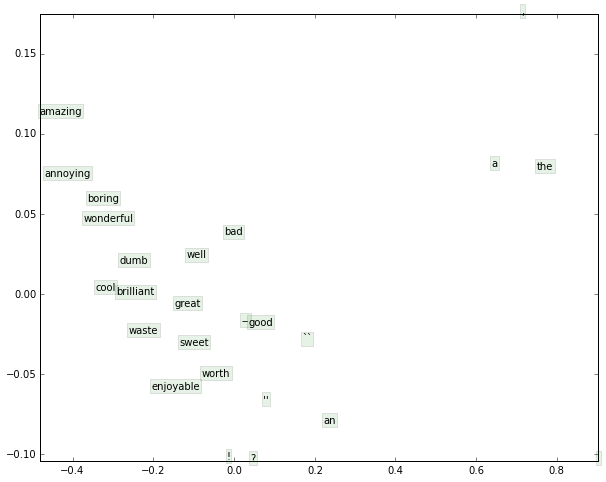

In [17]:
# Visualize the word vectors you trained

_, wordVectors0, _ = load_saved_params()
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])
visualizeWords = ["the", "a", "an", ",", ".", "?", "!", "``", "''", "--", "good", "great", "cool", "brilliant", "wonderful", "well", "amazing", "worth", "sweet", "enjoyable", "boring", "bad", "waste", "dumb", "annoying"]
visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2]) 

for i in xrange(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i], bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

## 4. Sentiment Analysis

Now, with the word vectors you trained, we are going to perform a simple sentiment analysis.

For each sentence in the Stanford Sentiment Treebank dataset, we are going to use the average of all the word vectors in that sentence as its feature, and try to predict the sentiment level of the said sentence. The sentiment level of the phrases are represented as real values in the original dataset, here we'll just use five classes:

    "very negative", "negative", "neutral", "positive", "very positive"
    
which are represented by 0 to 4 in the code, respectively.

For this part, you will learn to train a softmax regressor with SGD, and perform train/dev validation to improve generalization of your regressor.

In [119]:
# Now, implement some helper functions

def getSentenceFeature(tokens, wordVectors, sentence):
    """ Obtain the sentence feature for sentiment analysis by averaging its word vectors """
    ###################################################################
    # Implement computation for the sentence features given a         #
    # sentence.                                                       #
    # Inputs:                                                         #
    #   - tokens: a dictionary that maps words to their indices in    #
    #             the word vector list                                #
    #   - wordVectors: word vectors for all tokens                    #
    #   - sentence: a list of words in the sentence of interest       #
    # Output:                                                         #
    #   - sentVector: feature vector for the sentence                 #
    ###################################################################
    
    sentVector = np.zeros((wordVectors.shape[1],))
    
    ### YOUR CODE HERE
    for word in sentence:
        idx = tokens[word]
        sentVector += wordVectors[idx]
        
    sentVector /= len(sentence)
    ### END YOUR CODE
    
    return sentVector

def softmaxRegression(features, labels, weights, regularization = 0.0, nopredictions = False):
    """ Softmax Regression """
    ###################################################################
    # Implement softmax regression with weight regularization.        #
    # Inputs:                                                         #
    #   - features: feature vectors, each row is a feature vector     #
    #   - labels: labels corresponding to the feature vectors         #
    #   - weights: weights of the regressor                           #
    #   - regularization: L2 regularization constant                  #
    # Output:                                                         #
    #   - cost: cost of the regressor                                 #
    #   - grad: gradient of the regressor cost with respect to its    #
    #           weights                                               #
    #   - pred: label predictions of the regressor (you might find    #
    #           np.argmax helpful)                                    #
    ###################################################################
    
    prob = softmax(features.dot(weights))

    if len(features.shape) > 1:
        N = features.shape[0]
    else:
        N = 1
        
    # A vectorized implementation of    1/N * sum(cross_entropy(x_i, y_i)) + 1/2*|w|^2
    cost = np.sum(-np.log(prob[range(N), labels])) / N 
    cost += 0.5 * regularization * np.sum(weights ** 2)
    
    
    ### YOUR CODE HERE: compute the gradients and predictions
#    print(prob)
    pred = np.argmax(prob, axis=1)
     
#    print "features shape %d,%d" % features.shape
#    print "weights shape %d,%d" % weights.shape
#    print "prob shape %d,%d" % prob.shape
#    print "LABELS %s" % labels 
#    print " PREDS %s" % pred


    #for i in range(prob.shape[0]):
    #    print str(prob[i]) + " (row " + str(i) + ") sum = " + str(np.sum(prob[i]))

    
    # See http://cs224d.stanford.edu/lectures/CS224d-Lecture4.pdf
    # for gradients need to calculate dE/d_theta. 
    # = dE/dy * dy/d_theta. 
    # = (y_hat - target) * (x)
    #
    # then include regularization, which is just adding the lambda * theta value (derivative of lambda * 1/2*theta^2)
    #
    # finally divide by the number of examples to match the cost function (1/m)
    #
    # the tricky part is vectorizing it so we get the values for each class and weight in one operation

#    print "y_hat:\n%s\n\n" % prob
    
    # cross entropy + softmax derivative
    prob[range(N), labels] -= 1
    
#    print "delta:\n%s\n\n" % prob

    # derivative input (weights * features) WRT to weights, then summed over the examples
    grad = features.T.dot(prob)
    
    # now include the derivative of the regularization

#    print "grad:\n%s\n\n" % grad
    
    grad = grad / N

    grad += regularization * weights


    ### END YOUR CODE
    
    if nopredictions:
        return cost, grad
    else:
        return cost, grad, pred

def precision(y, yhat):
    """ Precision for classifier """
    assert(y.shape == yhat.shape)
    return np.sum(y == yhat) * 100.0 / y.size

def softmax_wrapper(features, labels, weights, regularization = 0.0):
    cost, grad, _ = softmaxRegression(features, labels, weights, regularization)
    return cost, grad

In [120]:
# Gradient check always comes first
random.seed(314159)
np.random.seed(265)
dummy_weights = 0.1 * np.random.randn(dimVectors, 5)
dummy_features = np.zeros((10, dimVectors))
dummy_labels = np.zeros((10,), dtype=np.int32)    
for i in xrange(10):
    words, dummy_labels[i] = dataset.getRandomTrainSentence()
    dummy_features[i, :] = getSentenceFeature(tokens, wordVectors, words)
print "==== Gradient check for softmax regression ===="
gradcheck_naive(lambda weights: softmaxRegression(dummy_features, dummy_labels, weights, 1, nopredictions = True), dummy_weights)

print "\n=== For autograder ==="
print softmaxRegression(dummy_features, dummy_labels, dummy_weights, 1.0)

==== Gradient check for softmax regression ====
Gradient check passed!

=== For autograder ===
(1.9087572203226311, array([[ 0.13471085,  0.0104175 ,  0.06464052,  0.14678234,  0.07468882],
       [-0.11082732, -0.0753506 ,  0.00940976,  0.09072251,  0.02397455],
       [ 0.02857999, -0.07050319,  0.00609608, -0.00242226, -0.08065193],
       [ 0.1165844 ,  0.23443669, -0.03104372, -0.05643964, -0.03242766],
       [ 0.16402121,  0.07514553, -0.06366103,  0.00533061, -0.24784793],
       [ 0.00873329, -0.03116552,  0.28757243,  0.11892055,  0.09353462],
       [-0.14699131, -0.16446357, -0.23492789, -0.14272223,  0.08556511],
       [ 0.10900431,  0.06290933, -0.03857583,  0.10949341, -0.11392697],
       [-0.25459777,  0.17492415,  0.07520622,  0.09168167,  0.02080977],
       [-0.05482908, -0.0023394 ,  0.10969091, -0.06085632,  0.10433387]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))


In [121]:
# Try different regularizations and pick the best!

### YOUR CODE HERE
regularizations = [0.0, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01]

best = 0
bestReg = 0
precisions = []
bestWeights = None
for regularization in regularizations:
    print 'REGULARIZATION IS %f' % regularization
#regularization = 0.0 # try 0.0, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01 and pick the best

### END YOUR CODE

    random.seed(3141)
    np.random.seed(59265)
    weights = np.random.randn(dimVectors, 5)

    trainset = dataset.getTrainSentences()
    nTrain = len(trainset)
    trainFeatures = np.zeros((nTrain, dimVectors))
    trainLabels = np.zeros((nTrain,), dtype=np.int32)

    for i in xrange(nTrain):
        words, trainLabels[i] = trainset[i]
        trainFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)
    
    # We will do batch optimization
    weights = sgd(lambda weights: softmax_wrapper(trainFeatures, trainLabels, weights, regularization), weights, 3.0, 10000, PRINT_EVERY=1000)

    # Prepare dev set features
    devset = dataset.getDevSentences()
    nDev = len(devset)
    devFeatures = np.zeros((nDev, dimVectors))
    devLabels = np.zeros((nDev,), dtype=np.int32)

    for i in xrange(nDev):
        words, devLabels[i] = devset[i]
        devFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)
    
    _, _, pred = softmaxRegression(devFeatures, devLabels, weights)
    
    prec = precision(devLabels, pred)
    print "Dev precision (%%): %f with regularization %f" % (prec, regularization)
    precisions.append(prec)
    if prec > best:
        print 'updating best reg to %f, (%f > %f)' % (regularization, prec, best)
        best = prec
        bestReg = regularization
        bestWeights = weights
    
print 'Best is %f with regularization %f' % (best, bestReg)
weights = bestWeights

REGULARIZATION IS 0.000000
*** iteration 1000: cost = 1.567704
*** iteration 2000: cost = 1.565386
*** iteration 3000: cost = 1.563709
*** iteration 4000: cost = 1.562423
*** iteration 5000: cost = 1.561398
*** iteration 6000: cost = 1.560558
*** iteration 7000: cost = 1.559860
*** iteration 8000: cost = 1.559271
*** iteration 9000: cost = 1.558770
*** iteration 10000: cost = 1.558341
Dev precision (%): 30.699364 with regularization 0.000000
updating best reg to 0.000000, (30.699364 > 0.000000)
REGULARIZATION IS 0.000010
*** iteration 1000: cost = 1.567956
*** iteration 2000: cost = 1.565790
*** iteration 3000: cost = 1.564312
*** iteration 4000: cost = 1.563243
*** iteration 5000: cost = 1.562440
*** iteration 6000: cost = 1.561819
*** iteration 7000: cost = 1.561332
*** iteration 8000: cost = 1.560945
*** iteration 9000: cost = 1.560635
*** iteration 10000: cost = 1.560385
Dev precision (%): 30.699364 with regularization 0.000010
REGULARIZATION IS 0.000030
*** iteration 1000: cost = 

In [122]:
# Write down the best regularization and accuracy you found
# sanity check: your accuracy should be around or above 30%

### YOUR CODE HERE

BEST_REGULARIZATION = 1
BEST_ACCURACY = 0.0

### END YOUR CODE

print "=== For autograder ===\n%g\t%g" % (BEST_REGULARIZATION, BEST_ACCURACY)

=== For autograder ===
1	0


In [123]:
# Test your findings on the test set

testset = dataset.getTestSentences()
nTest = len(testset)
testFeatures = np.zeros((nTest, dimVectors))
testLabels = np.zeros((nTest,), dtype=np.int32)

for i in xrange(nTest):
    words, testLabels[i] = testset[i]
    testFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)
    
_, _, pred = softmaxRegression(testFeatures, testLabels, weights)
print "=== For autograder ===\nTest precision (%%): %f" % precision(testLabels, pred)

=== For autograder ===
Test precision (%): 28.235294


#### Extra Credit

Train your own classifier for sentiment analysis! We will not provide any starter code for this part, but you can feel free to reuse the code you've written before, or write some new code for this task. Also feel free to refer to the code we provided you with to see how we scaffolded training for you.

Try to contain all of your code in one code block. You could start by using multiple blocks, then paste code together and remove unnecessary blocks. Report, as the last two lines of the output of your block, the dev set accuracy and test set accuracy you achieved, in the format we used above.

*Note: no credits will be given for this part if you use the dev or test sets for training, or if you fine-tune your regularization or other hyperparameters on the test set.*

In [ ]:
### YOUR CODE HERE

### END YOU CODE


_, _, pred = softmaxRegression(devFeatures, devLabels, weights)
print "=== For autograder ===\nDev precision (%%): %f" % precision(devLabels, pred)
_, _, pred = softmaxRegression(testFeatures, testLabels, weights)
print "Test precision (%%): %f" % precision(testLabels, pred)